# Using PCA and Logistic Regression on SQF data

This notebook takes 2015 SQF data from NYPD and transforms it to numeric data and factorizes categorical variables. In the first stage of exploration, I took only numeric data and attempted to use PCA to reduce variables in order to visualize. I removed  date-time variables in this process. Next, I take cherry-picked variables that are least "problematic" and repeat PCA. I split the resulting projection into training and testing datasets. With the training set, I run a logistic regression with the first two eigenvectors as the explanatory variable and "arrest made" as the dependent binary variable. I then use the testing dataset to predict whether an arrest was made or not. The regression model has:

Precision = 73.97%

Accuracy = 89.54%

Recall = 58.15%

In [2]:
import pandas as pd
import numpy as np
from StringIO import StringIO
from zipfile import ZipFile
from urllib import urlopen
import requests
import csv
import matplotlib.pylab as plt
import seaborn as sns
import pylab as pylab
from collections import OrderedDict
import numpy as np
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from matplotlib.pylab import plt
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
%pylab inline
%matplotlib inline

/opt/ds/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy


In [3]:
def unzip_file(year):
    file_path = 'data/{}_sqf_csv.zip'.format(year)
    zipdir = ZipFile(file_path)
    zipdir.extractall('data')

In [4]:
def unzip_read_file(year):
    url = urlopen("http://www.nyc.gov/html/nypd/downloads/zip/analysis_and_planning/{}_sqf_csv.zip".format(year))
    zipfile = ZipFile(StringIO(url.read()))
    try:
        with zipfile.open("{}.csv".format(year)) as file:
            df = pd.read_csv(file)
    except: # 2015 csv name is different format than all the rest...go figure.
        with zipfile.open("{}_sqf_csv.csv".format(year)) as file:
            df = pd.read_csv(file)
    return df

In [5]:
df2015 = unzip_read_file(2015)

In [6]:
# Data cleaning to generate numeric values


d = {'Y': True, 'N': False}
df2015 = df2015.replace(d)
df2015 = df2015*1

# "get numeric data" only takes numeric data in the df, it was a quick
# and easy way to get PCA to work, but it ignores a lot of key variables
# like race and crime suspected of. However, it still retains a majority of
# variables (75/112 variables)

df2015Num = df2015._get_numeric_data()
df2015Num.shape

(22563, 75)

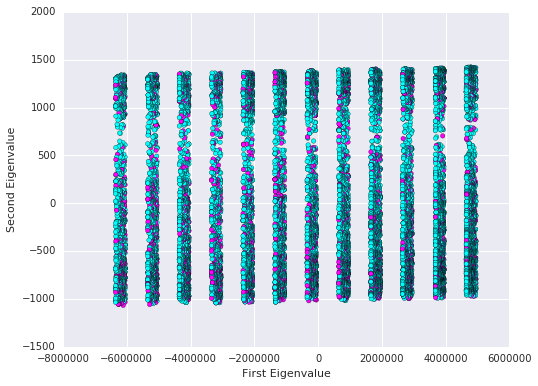

In [7]:
n=3 # how many eigenvectors we choose
pca = PCA(n)
Proj = pca.fit_transform(df2015Num)
eigenvalues = pca.explained_variance_
plt.figure(2, figsize=(8, 6))
plt.clf()
# Plot the training points
plt.scatter(Proj[:, 0], Proj[:, 1], c=df2015.arstmade, cmap=plt.cm.cool)
plt.xlabel('First Eigenvalue')
plt.ylabel('Second Eigenvalue')
plt.show()

## This is the plot of the first two eigenvectors colored by "arrest made". The "datestop" variable is "overwhelming" the rest of the data, causing the 12 clusters we see here. I'll remove this variable later on.

In [8]:
dfNoDate = df2015Num.drop(['datestop'],axis=1)

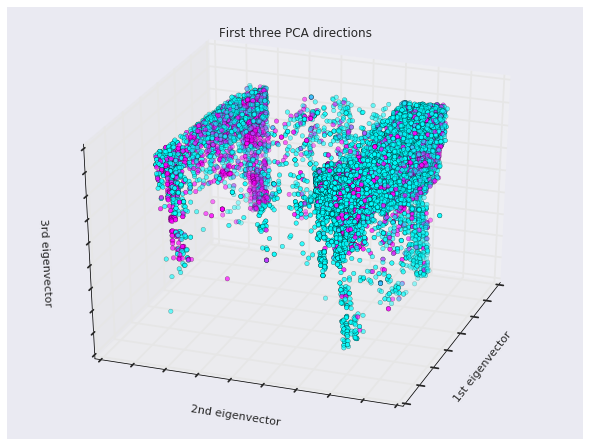

In [9]:
n=3 # how many eigenvectors we choose
pca = PCA(n)
Proj = pca.fit_transform(dfNoDate)
eigenvalues = pca.explained_variance_
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=160)
ax.scatter(Proj[:, 0], Proj[:, 1], Proj[:, 2],c=df2015.arstmade,
           cmap=plt.cm.cool)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

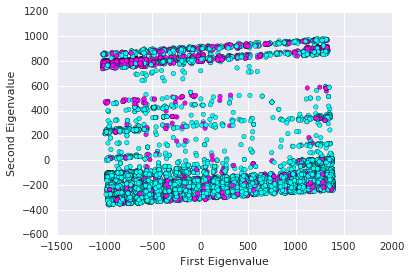

In [10]:
plt.clf()
# Plot the training points
plt.scatter(Proj[:, 0], Proj[:, 1], c=df2015.arstmade, cmap=plt.cm.cool)
plt.xlabel('First Eigenvalue')
plt.ylabel('Second Eigenvalue')
plt.show()

## It's starting to look a little more "clustery"... let's see what happens when we remove "timestop" as well

In [11]:
dfNoDateTime = dfNoDate.drop(['timestop'],axis=1)

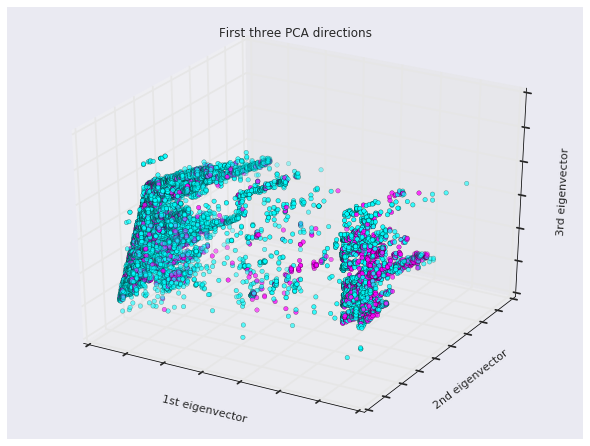

In [12]:
n=3 # how many eigenvectors we choose
pca = PCA(n)
Proj = pca.fit_transform(dfNoDateTime)
eigenvalues = pca.explained_variance_
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=60)
ax.scatter(Proj[:, 0], Proj[:, 1], Proj[:, 2],c=df2015.arstmade,
           cmap=plt.cm.cool)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

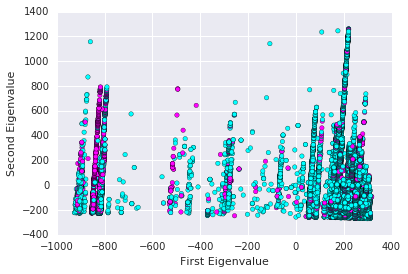

In [13]:
plt.clf()
# Plot the training points
plt.scatter(Proj[:, 0], Proj[:, 1], c=df2015.arstmade, cmap=plt.cm.cool)
plt.xlabel('First Eigenvalue')
plt.ylabel('Second Eigenvalue')
plt.show()

## I'm starting to see more patterns here! It looks like there's a cluster on the left where "Arrest Made" (pink color) is more prominent. Time to see what the major shared characteristics of that cluster are... to be continued.

In [14]:
sqf_primary_select = df2015.loc[:,['inout', 'explnstp', 'arstmade', 
      'sumissue', 'frisked', 'searched', 'contrabn',  
      'rf_vcrim', 'rf_othsw', 'rf_attir', 'cs_objcs', 'cs_descr', 
      'cs_casng', 'cs_lkout', 'rf_vcact', 'cs_cloth', 'cs_drgtr', 
      'cs_furtv', 'rf_rfcmp', 'rf_verbl', 'cs_vcrim', 'cs_bulge', 
      'cs_other',  'rf_knowl',  'sb_hdobj', 'sb_outln', 'sb_admis', 
      'sb_other', 'rf_furt', 'rf_bulg',  'sex', 'race']]

These "select" variables have been hand-picked as the least problematic to work with. The variables we discarded include text descriptions and irratic data.

In [15]:
def fix_nans(column):
    if column in [' ', '  ', '']:
        column = np.nan
    
    return column

In [16]:
for i in sqf_primary_select.columns:
    sqf_primary_select[i] = sqf_primary_select[i].apply(fix_nans)

In [17]:
len(sqf_primary_select)

22563

In [18]:
sqf_primary_select.dropna(inplace=True)
len(sqf_primary_select)

22563

In [19]:
sqf_primary_select.head()

,inout,explnstp,arstmade,sumissue,frisked,searched,contrabn,rf_vcrim,rf_othsw,rf_attir,...,cs_other,rf_knowl,sb_hdobj,sb_outln,sb_admis,sb_other,rf_furt,rf_bulg,sex,race
0,O,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,M,W
1,O,1,0,0,1,0,0,1,1,0,...,1,0,0,0,0,0,0,0,M,B
2,O,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,M,B
3,O,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,M,B
4,O,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,M,B


In [20]:
d = {'Y': True, 'N': False}
sqf_primary_select = sqf_primary_select.replace(d)
df2015 = df2015*1


In [21]:
sqf_primary_numeric = pd.get_dummies(sqf_primary_select)

In [22]:
sqf_primary_numeric.head()

,explnstp,arstmade,sumissue,frisked,searched,contrabn,rf_vcrim,rf_othsw,rf_attir,cs_objcs,...,sex_M,sex_Z,race_A,race_B,race_I,race_P,race_Q,race_U,race_W,race_Z
0,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,1,0,0,1,1,0,0,...,1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


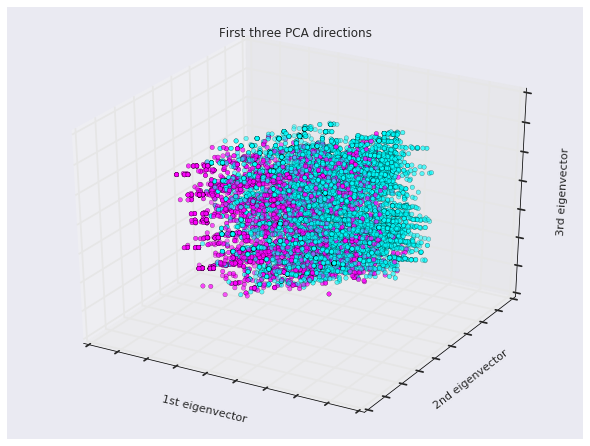

In [23]:
n=3 # how many eigenvectors we choose
pca = PCA(n)
Proj = pca.fit_transform(sqf_primary_numeric)
eigenvalues = pca.explained_variance_
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=60)
ax.scatter(Proj[:, 0], Proj[:, 1], Proj[:, 2],c=sqf_primary_numeric.arstmade,
           cmap=plt.cm.cool)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

/opt/ds/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


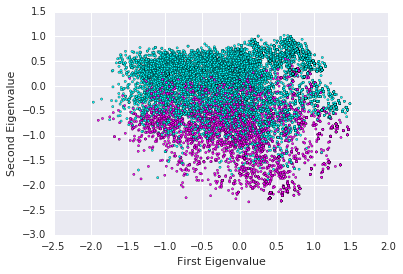

In [24]:
plt.clf()
# Plot the training points
plt.scatter(Proj[:, 0], Proj[:, 1], c=sqf_primary_numeric.arstmade, cmap=plt.cm.cool, marker='.')
plt.xlabel('First Eigenvalue')
plt.ylabel('Second Eigenvalue')
plt.legend()
plt.show()

### Yay! This looks clustery! Let's do some logistic regression

In [25]:
df_2log = pd.DataFrame(Proj)

In [26]:
df_2log['arstmade']=sqf_primary_numeric.arstmade

In [27]:
df_2log.columns=['1st','2nd','3rd','arstmade']

In [28]:
df_2log.head()

,1st,2nd,3rd,arstmade
0,0.055402,0.683453,-0.188115,0
1,-0.397749,-0.120701,0.898213,0
2,0.279170,0.250067,0.308106,0
3,0.279170,0.250067,0.308106,0
4,0.279170,0.250067,0.308106,0


In [29]:
df_2log.shape

(22563, 4)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_2log[['1st','2nd']], df_2log['arstmade'], test_size=.4)

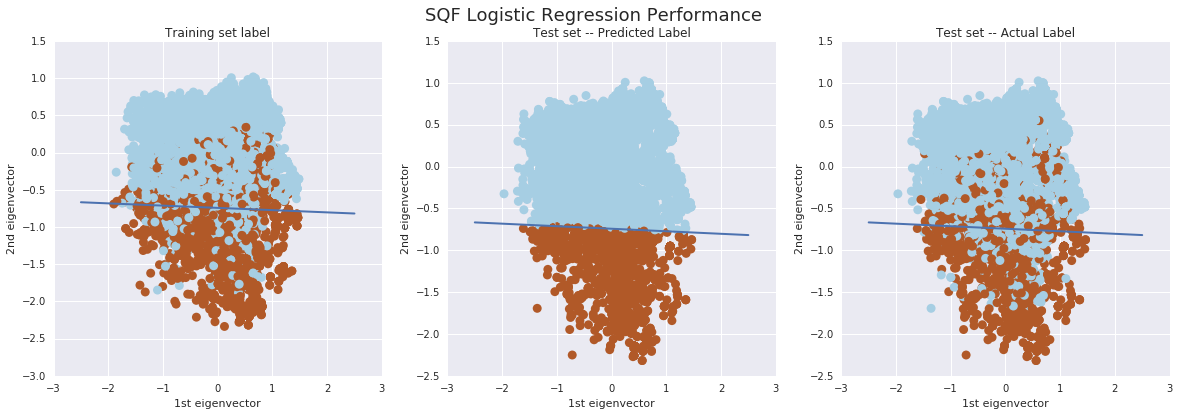

Precision = 76.09%
Accuracy = 89.18%
Recall = 55.99%


In [31]:
lr = LogisticRegression(C=1e6)
lr.fit(X_train, y_train)
pre = lr.predict(X_test)

fig3 = plt.figure(figsize = (20,6))
plt.suptitle("SQF Logistic Regression Performance", fontsize = 18)
ax1, ax2, ax3 = fig3.add_subplot(131), fig3.add_subplot(132), fig3.add_subplot(133)
xplot = np.linspace(-2.5,2.5,200)
yplot = -(lr.intercept_[0] + lr.coef_[0][0]*xplot)/lr.coef_[0][1]
ax1.plot(xplot,yplot,lw = 2)
ax2.plot(xplot,yplot,lw = 2)
ax3.plot(xplot,yplot,lw = 2)
ax1.set(title='Training set label', xlabel = '1st eigenvector', ylabel = '2nd eigenvector')
ax2.set(title='Test set -- Predicted Label', xlabel = '1st eigenvector', ylabel = '2nd eigenvector')
ax3.set(title='Test set -- Actual Label', xlabel = '1st eigenvector', ylabel = '2nd eigenvector')
ax1.scatter(X_train['1st'], X_train['2nd'], lw = 0, s = 80, c = y_train, cmap=plt.cm.Paired, label='test')
ax2.scatter(X_test['1st'], X_test['2nd'], lw = 0, s = 80, c = pre, cmap=plt.cm.Paired)
ax3.scatter(X_test['1st'], X_test['2nd'], lw = 0, s = 80, c = y_test, cmap=plt.cm.Paired)
plt.show()

#compute TP,FP,FN,TN for the above classification
TP = sum((pre==1)&(y_test==1))
FP = sum((pre==1)&(y_test==0))
FN = sum((pre==0)&(y_test==1))
TN = sum((pre==0)&(y_test==0))
#compute precision, accuracy and recall
Acc = 100.0 * (TP+TN)/(TP+TN+FP+FN)
Rec = 100.0 * TP/(TP+FN)
Prec= 100.0 * TP/(TP+FP)
print('Precision = %.2f%%\nAccuracy = %.2f%%\nRecall = %.2f%%'%(Prec,Acc,Rec))

In [35]:
df_2log.groupby(by='arstmade').agg('count')

,1st,2nd,3rd
arstmade,,,
0,18595,18595,18595
1,3968,3968,3968


In [42]:
sqf_primary_numeric.columns

Index([u'explnstp', u'arstmade', u'sumissue', u'frisked', u'searched',
       u'contrabn', u'rf_vcrim', u'rf_othsw', u'rf_attir', u'cs_objcs',
       u'cs_descr', u'cs_casng', u'cs_lkout', u'rf_vcact', u'cs_cloth',
       u'cs_drgtr', u'cs_furtv', u'rf_rfcmp', u'rf_verbl', u'cs_vcrim',
       u'cs_bulge', u'cs_other', u'rf_knowl', u'sb_hdobj', u'sb_outln',
       u'sb_admis', u'sb_other', u'rf_furt', u'rf_bulg', u'inout_I',
       u'inout_O', u'sex_F', u'sex_M', u'sex_Z', u'race_A', u'race_B',
       u'race_I', u'race_P', u'race_Q', u'race_U', u'race_W', u'race_Z'],
      dtype='object')

In [44]:
X = sqf_primary_numeric[[u'explnstp', u'sumissue', u'frisked', u'searched',
       u'contrabn', u'rf_vcrim', u'rf_othsw', u'rf_attir', u'cs_objcs',
       u'cs_descr', u'cs_casng', u'cs_lkout', u'rf_vcact', u'cs_cloth',
       u'cs_drgtr', u'cs_furtv', u'rf_rfcmp', u'rf_verbl', u'cs_vcrim',
       u'cs_bulge', u'cs_other', u'rf_knowl', u'sb_hdobj', u'sb_outln',
       u'sb_admis', u'sb_other', u'rf_furt', u'rf_bulg', u'inout_I',
       u'inout_O', u'sex_F', u'sex_M', u'sex_Z', u'race_A', u'race_B',
       u'race_I', u'race_P', u'race_Q', u'race_U', u'race_W', u'race_Z']]

In [50]:
Y = sqf_primary_numeric[['arstmade']]

## Naive Bayes

In [52]:
#Import Library of Bernoulli Naive Bayes model
from sklearn.naive_bayes import BernoulliNB
import numpy as np

#assigning predictor and target variables
x= np.array(X)
Y = np.array(Y)

In [63]:
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(x, Y, test_size=.4)

In [71]:
X_B_train

array([[ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

In [68]:
#Create a Bernoulli Classifier
model = BernoulliNB()

# Train the model using the training sets 
model.fit(X_B_train, y_B_train)

/opt/ds/local/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [69]:
#Predict Output 
predicted= model.predict(X_B_test)
print predicted

[0 0 0 ..., 0 0 0]


In [97]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(predicted, y_B_test))
conf_matrix = confusion_matrix(predicted, y_B_test)
TP = conf_matrix[0,0]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
TN = conf_matrix[1,1]
#compute precision, accuracy and recall
Acc = 100.0 * (TP+TN)/(TP+TN+FP+FN)
Rec = 100.0 * TP/(TP+FN)
Prec= 100.0 * TP/(TP+FP)
print('Precision = %.2f%%\nAccuracy = %.2f%%\nRecall = %.2f%%'%(Prec,Acc,Rec))

[[6967  616]
 [ 479  964]]
Precision = 91.88%
Accuracy = 87.87%
Recall = 93.57%


In [83]:
print "True Arrests", TP
print "False Arrests", FP
print "False Negative", FN
print "True Negative", TN

True Arrests 2279940
False Arrests 10744578
False Negative 11981140
True Negative 56463018


[[6967  616]
 [ 479  964]]


In [94]:
TP

6967